# **Install and Load Libraries**

In [ ]:
!pip install -q twint
!pip install pyLDAvis #Install pyLDAvis library for interactive topic visualization dashboard.

In [ ]:
# Loading primary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For twitter scraping
import twint

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Data Extraction and Cleaning**

## Design the scraping parameters


Each scrape is being run independently as the input parameters are adjusted for each key word. Earlier iteractions indicated that without specifying the 'To' statement for @Coles there are alot of unrelated responses. The dataset could be further sharpened using 'Near' and specifiying all major Australian cities but this would limit rural responses.

### Dataset 1 #Coles - Set the parameters

In [ ]:
keyword1 = '#Coles'

In [ ]:
since_date = "2020-01-01 00:00:00" #input for dataset 1 and 2

In [ ]:
  # Dataset 1 #Coles - Input and Output parameters
  c               = twint.Config()
  c.Search        = keyword1
  c.Since         = since_date
  c.Location      = True
  c.Lang          = "en"
  c.Store_csv     = True
  c.Store_pandas  = True
  c.Pandas_clean  = True
  c.Pandas_au     = True
  c.Output        = keyword1

In [ ]:
# Dataset 1 #Coles - Format the output attributes
c.Format = "Tweet id: {id} | Tweet: {tweet} | Likes: {likes_count} | Retweets: {retweets_count} | Date: {date} | Time: {time} | UserID: {user_id} | Username: {username} | Place: {place} | Geo: {geo}"

In [ ]:
# Dataset 1 #Coles - Python exception handling
try:
  twint.run.Search(c)
except:
  print('Error in {}'.format(keyword1))  

print('\n\nCompleted {}\n\n'.format(keyword1))

### Dataset 2 @Coles - Set the parameters

In [ ]:
keyword2 = '@Coles'

In [ ]:
 # Dataset 2 @Coles - Input and Output parameters
 d               = twint.Config()
 d.search        = keyword2
 d.Since         = since_date
 d.Location      = True
 d.Lang          = "en"
 d.To            = "@coles"
 d.Store_csv     = True
 d.Store_pandas  = True
 d.Pandas_clean  = True
 d.Pandas_au     = True
 d.Output        = keyword2


In [ ]:
# Dataset 2 @Coles - Format the output attributes
d.Format = "Tweet id: {id} | Tweet: {tweet} | Likes: {likes_count} | Retweets: {retweets_count} | Date: {date} | Time: {time} | UserID: {user_id} | Username: {username} | Place: {place} | Geo: {geo}"

In [ ]:
# Dataset 2 @Coles - Python exception handling
try:
  twint.run.Search(d)
except:
  print('Error in {}'.format(keyword2))  

print('\n\nCompleted {}\n\n'.format(keyword2))

## Load Dataset

Due to the length of time taken to run the above output is downloaded and stored as a csv rather then generating a dataframe each time.

In [ ]:
#Access datasets from google drive
from google.colab import drive
drive.mount('/content/drive/') #mount google drive

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Load required datasets
df_1   = pd.read_csv('drive/My Drive/Data/coles_user.csv')
df_2   = pd.read_csv('drive/My Drive/Data/coles_hashtag.csv') 

If you the code above is rerun, the most recent version can be loaded without downloading to drive/My Drive/Data/. Just comment out the previous step and uncomment this step.

In [ ]:
#load csv as panda dataframes local
#df_1= pd.read_csv('#coles.csv')
#df_2 = pd.read_csv('@coles.csv')

In [ ]:
df_1.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1256783985499205634,1256783985499205634,1588475626000,2020-05-03,03:13:46,UTC,403197899,stewart17oakden,Stewart Johnston,NaN,@Coles enlighten me if U would. Disclaimer: Fu...,['coles'],[],[],1,0,0,['#covid19au'],[],https://twitter.com/Stewart17Oakden/status/125...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '403197899', 'username': 'Stewart...",NaN,NaN,NaN,NaN
1,1256770046199689218,1256770046199689218,1588472303000,2020-05-03,02:18:23,UTC,260726460,volks2911,Volkan Kalayci * 🔴⚽️🔴⚽️,NaN,@Coles making shoppers pack their own bags to ...,['coles'],[],[],0,0,0,"['#covid__19', '#scam', '#lazy']",[],https://twitter.com/volks2911/status/125677004...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '260726460', 'username': 'volks29...",NaN,NaN,NaN,NaN
2,1256746444360278016,1256438381514387457,1588466676000,2020-05-03,00:44:36,UTC,900604458589052928,janemangel,Jane Angel,NaN,I’m not talking about fruit and vegies here( w...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JaneMAngel/status/12567464...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '900604458589052928', 'username':...",NaN,NaN,NaN,NaN
3,1256727968140849152,1256475821981622272,1588462271000,2020-05-02,23:31:11,UTC,23501166,jeneng,Jennifer (wash your hands) English,NaN,It was Figtree. I shop there every week & they...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JenEng/status/125672796814...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '23501166', 'username': 'JenEng'}...",NaN,NaN,NaN,NaN
4,1256692773127766018,1256433718421417985,1588453879000,2020-05-02,21:11:19,UTC,1866363362,lemuriankaryn,Karyn Jane is staying home 🔮🌞,NaN,"Good to see this. FYI, I had the same experien...","['coles', 'hcheese_board']",[],[],0,0,1,[],[],https://twitter.com/lemuriankaryn/status/12566...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1866363362', 'username': 'lemuri...",NaN,NaN,NaN,NaN


In [ ]:
df_2.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1256544031317737477,1256544031317737477,1588418417000,2020-05-02,11:20:17,UTC,1054337318356566016,emfiddes,em,NaN,australia trying to keep up with the rest of t...,[],[],['https://pbs.twimg.com/media/EXAkIVzU4AARdNZ....,0,0,2,['#coles'],[],https://twitter.com/EmFiddes/status/1256544031...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1054337318356566016', 'username'...",NaN,NaN,NaN,NaN
1,1256539696605216769,1256539696605216769,1588417383000,2020-05-02,11:03:03,UTC,3252070271,nowsydney,Gypsy Life,NaN,Stores now stacked up with toilet paper after ...,[],[],[],0,0,1,"['#toiletpapercrisis', '#toiletpaperpanic', '#...",[],https://twitter.com/NowSydney/status/125653969...,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '3252070271', 'username': 'NowSyd...",NaN,NaN,NaN,NaN
2,1256485079829766144,1256485079829766144,1588404362000,2020-05-02,07:26:02,UTC,1118131547754909699,only1robbied,Rob Dagostino,NaN,Since I’ve been alive I’ve definitely gone thr...,[],[],[],0,0,1,['#coles'],[],https://twitter.com/Only1robbieD/status/125648...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1118131547754909699', 'username'...",NaN,NaN,NaN,NaN
3,1256417973935325184,1256417973935325184,1588388362000,2020-05-02,02:59:22,UTC,815069427985051649,buyholdlong,"Buy, Hold Long - Personal Finance Blogger",NaN,A Comparison Of Coles vs. Woolworths – #Coles ...,[],['https://www.buyholdlong.com/2020/04/21/a-com...,[],0,0,0,"['#coles', '#woolies', '#col', '#wow', '#perso...",[],https://twitter.com/BuyHoldLong/status/1256417...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '815069427985051649', 'username':...",NaN,NaN,NaN,NaN
4,1256412002869604353,1256412002869604353,1588386939000,2020-05-02,02:35:39,UTC,522197005,chatnoir_1,jane dough,NaN,Absolutely furious my local #coles opened all...,[],[],[],1,0,1,['#coles'],[],https://twitter.com/chatnoir_1/status/12564120...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '522197005', 'username': 'chatnoi...",NaN,NaN,NaN,NaN


# **Text Pre-processing**

In [ ]:
# Create a new flag column for both datasets
df_1['source'] = 'user'
df_2['source'] = 'hashtag'
df_2.head() #validate new column

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1256544031317737477,1256544031317737477,1588418417000,2020-05-02,11:20:17,UTC,1054337318356566016,emfiddes,em,NaN,australia trying to keep up with the rest of t...,[],[],['https://pbs.twimg.com/media/EXAkIVzU4AARdNZ....,0,0,2,['#coles'],[],https://twitter.com/EmFiddes/status/1256544031...,False,NaN,0,NaN,NaN,hashtag,NaN,NaN,NaN,"[{'user_id': '1054337318356566016', 'username'...",NaN,NaN,NaN,NaN
1,1256539696605216769,1256539696605216769,1588417383000,2020-05-02,11:03:03,UTC,3252070271,nowsydney,Gypsy Life,NaN,Stores now stacked up with toilet paper after ...,[],[],[],0,0,1,"['#toiletpapercrisis', '#toiletpaperpanic', '#...",[],https://twitter.com/NowSydney/status/125653969...,False,NaN,1,NaN,NaN,hashtag,NaN,NaN,NaN,"[{'user_id': '3252070271', 'username': 'NowSyd...",NaN,NaN,NaN,NaN
2,1256485079829766144,1256485079829766144,1588404362000,2020-05-02,07:26:02,UTC,1118131547754909699,only1robbied,Rob Dagostino,NaN,Since I’ve been alive I’ve definitely gone thr...,[],[],[],0,0,1,['#coles'],[],https://twitter.com/Only1robbieD/status/125648...,False,NaN,0,NaN,NaN,hashtag,NaN,NaN,NaN,"[{'user_id': '1118131547754909699', 'username'...",NaN,NaN,NaN,NaN
3,1256417973935325184,1256417973935325184,1588388362000,2020-05-02,02:59:22,UTC,815069427985051649,buyholdlong,"Buy, Hold Long - Personal Finance Blogger",NaN,A Comparison Of Coles vs. Woolworths – #Coles ...,[],['https://www.buyholdlong.com/2020/04/21/a-com...,[],0,0,0,"['#coles', '#woolies', '#col', '#wow', '#perso...",[],https://twitter.com/BuyHoldLong/status/1256417...,False,NaN,0,NaN,NaN,hashtag,NaN,NaN,NaN,"[{'user_id': '815069427985051649', 'username':...",NaN,NaN,NaN,NaN
4,1256412002869604353,1256412002869604353,1588386939000,2020-05-02,02:35:39,UTC,522197005,chatnoir_1,jane dough,NaN,Absolutely furious my local #coles opened all...,[],[],[],1,0,1,['#coles'],[],https://twitter.com/chatnoir_1/status/12564120...,False,NaN,0,NaN,NaN,hashtag,NaN,NaN,NaN,"[{'user_id': '522197005', 'username': 'chatnoi...",NaN,NaN,NaN,NaN


In [ ]:
# Combine the 2 datasets
df = pd.concat([df_1, df_2], ignore_index=True)
df.info() # validate merge

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7029 entries, 0 to 7028
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7029 non-null   int64  
 1   conversation_id  7029 non-null   int64  
 2   created_at       7029 non-null   int64  
 3   date             7029 non-null   object 
 4   time             7029 non-null   object 
 5   timezone         7029 non-null   object 
 6   user_id          7029 non-null   int64  
 7   username         7029 non-null   object 
 8   name             7029 non-null   object 
 9   place            386 non-null    object 
 10  tweet            7029 non-null   object 
 11  mentions         7029 non-null   object 
 12  urls             7029 non-null   object 
 13  photos           7029 non-null   object 
 14  replies_count    7029 non-null   int64  
 15  retweets_count   7029 non-null   int64  
 16  likes_count      7029 non-null   int64  
 17  hashtags      

In [ ]:
# Transform tweet into lowercase
df['tweet'] = df['tweet'].str.lower()
df.head() #validate output

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1256783985499205634,1256783985499205634,1588475626000,2020-05-03,03:13:46,UTC,403197899,stewart17oakden,Stewart Johnston,NaN,@coles enlighten me if u would. disclaimer: fu...,['coles'],[],[],1,0,0,['#covid19au'],[],https://twitter.com/Stewart17Oakden/status/125...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '403197899', 'username': 'Stewart...",NaN,NaN,NaN,NaN
1,1256770046199689218,1256770046199689218,1588472303000,2020-05-03,02:18:23,UTC,260726460,volks2911,Volkan Kalayci * 🔴⚽️🔴⚽️,NaN,@coles making shoppers pack their own bags to ...,['coles'],[],[],0,0,0,"['#covid__19', '#scam', '#lazy']",[],https://twitter.com/volks2911/status/125677004...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '260726460', 'username': 'volks29...",NaN,NaN,NaN,NaN
2,1256746444360278016,1256438381514387457,1588466676000,2020-05-03,00:44:36,UTC,900604458589052928,janemangel,Jane Angel,NaN,i’m not talking about fruit and vegies here( w...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JaneMAngel/status/12567464...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '900604458589052928', 'username':...",NaN,NaN,NaN,NaN
3,1256727968140849152,1256475821981622272,1588462271000,2020-05-02,23:31:11,UTC,23501166,jeneng,Jennifer (wash your hands) English,NaN,it was figtree. i shop there every week & they...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JenEng/status/125672796814...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '23501166', 'username': 'JenEng'}...",NaN,NaN,NaN,NaN
4,1256692773127766018,1256433718421417985,1588453879000,2020-05-02,21:11:19,UTC,1866363362,lemuriankaryn,Karyn Jane is staying home 🔮🌞,NaN,"good to see this. fyi, i had the same experien...","['coles', 'hcheese_board']",[],[],0,0,1,[],[],https://twitter.com/lemuriankaryn/status/12566...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '1866363362', 'username': 'lemuri...",NaN,NaN,NaN,NaN


## Filter out unrelated records

In [ ]:
# Filter the dataset select unrelated users with high frequency tweets
# this list has been determined through previous iternations
indexusers = df[ (df['username'] == 'colesbakerycafe') | (df['username'] == 'Coles Books') | (df['username'] == 'colestastywelsh') | (df['username'] == 'colesthebookppl') ].index 
df.drop(indexusers , inplace=True)

In [ ]:
print(df.shape)

(6955, 34)


## Remove Twitter User Id

In [ ]:
#remove twitter user id's within the tweet text.
def remove_twitter_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) # remove multiple spaces
  return spaces_removed

df['tweet'] = df['tweet'].apply(remove_twitter_ids)
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1256783985499205634,1256783985499205634,1588475626000,2020-05-03,03:13:46,UTC,403197899,stewart17oakden,Stewart Johnston,NaN,enlighten me if u would disclaimer fully supp...,['coles'],[],[],1,0,0,['#covid19au'],[],https://twitter.com/Stewart17Oakden/status/125...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '403197899', 'username': 'Stewart...",NaN,NaN,NaN,NaN
1,1256770046199689218,1256770046199689218,1588472303000,2020-05-03,02:18:23,UTC,260726460,volks2911,Volkan Kalayci * 🔴⚽️🔴⚽️,NaN,making shoppers pack their own bags to minimi...,['coles'],[],[],0,0,0,"['#covid__19', '#scam', '#lazy']",[],https://twitter.com/volks2911/status/125677004...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '260726460', 'username': 'volks29...",NaN,NaN,NaN,NaN
2,1256746444360278016,1256438381514387457,1588466676000,2020-05-03,00:44:36,UTC,900604458589052928,janemangel,Jane Angel,NaN,im not talking about fruit and vegies here whi...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JaneMAngel/status/12567464...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '900604458589052928', 'username':...",NaN,NaN,NaN,NaN
3,1256727968140849152,1256475821981622272,1588462271000,2020-05-02,23:31:11,UTC,23501166,jeneng,Jennifer (wash your hands) English,NaN,it was figtree i shop there every week they ha...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JenEng/status/125672796814...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '23501166', 'username': 'JenEng'}...",NaN,NaN,NaN,NaN
4,1256692773127766018,1256433718421417985,1588453879000,2020-05-02,21:11:19,UTC,1866363362,lemuriankaryn,Karyn Jane is staying home 🔮🌞,NaN,good to see this fyi i had the same experience...,"['coles', 'hcheese_board']",[],[],0,0,1,[],[],https://twitter.com/lemuriankaryn/status/12566...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '1866363362', 'username': 'lemuri...",NaN,NaN,NaN,NaN


## Delete Redundant Variables

In [ ]:
#remove redundant features
#features_drop = ['username', 'mentions',]
#df_train1 = df_train1.drop(features_drop, axis=1)

## Duplicate Removal

In [ ]:
# Check duplicate tweets count
duplicate_count = len(df['tweet'])-len(df['tweet'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df.shape[0])

duplicate count: 150
total records before remove duplicates: 6955


In [ ]:
# drop duplicates (keep the last tweet of each of the duplicates)
df = df.drop_duplicates(subset='tweet', keep="last")
print('updated record count:', df.shape[0])

updated record count: 6805


## Remove Punctuations

In [ ]:
# Remove punctuations
df['tweet'] = df['tweet'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1256783985499205634,1256783985499205634,1588475626000,2020-05-03,03:13:46,UTC,403197899,stewart17oakden,Stewart Johnston,NaN,enlighten me if u would disclaimer fully supp...,['coles'],[],[],1,0,0,['#covid19au'],[],https://twitter.com/Stewart17Oakden/status/125...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '403197899', 'username': 'Stewart...",NaN,NaN,NaN,NaN
1,1256770046199689218,1256770046199689218,1588472303000,2020-05-03,02:18:23,UTC,260726460,volks2911,Volkan Kalayci * 🔴⚽️🔴⚽️,NaN,making shoppers pack their own bags to minimi...,['coles'],[],[],0,0,0,"['#covid__19', '#scam', '#lazy']",[],https://twitter.com/volks2911/status/125677004...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '260726460', 'username': 'volks29...",NaN,NaN,NaN,NaN
2,1256746444360278016,1256438381514387457,1588466676000,2020-05-03,00:44:36,UTC,900604458589052928,janemangel,Jane Angel,NaN,im not talking about fruit and vegies here whi...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JaneMAngel/status/12567464...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '900604458589052928', 'username':...",NaN,NaN,NaN,NaN
3,1256727968140849152,1256475821981622272,1588462271000,2020-05-02,23:31:11,UTC,23501166,jeneng,Jennifer (wash your hands) English,NaN,it was figtree i shop there every week they ha...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JenEng/status/125672796814...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '23501166', 'username': 'JenEng'}...",NaN,NaN,NaN,NaN
4,1256692773127766018,1256433718421417985,1588453879000,2020-05-02,21:11:19,UTC,1866363362,lemuriankaryn,Karyn Jane is staying home 🔮🌞,NaN,good to see this fyi i had the same experience...,"['coles', 'hcheese_board']",[],[],0,0,1,[],[],https://twitter.com/lemuriankaryn/status/12566...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '1866363362', 'username': 'lemuri...",NaN,NaN,NaN,NaN


## Stop words removal

In [ ]:
#Remove stop words
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# get the list of all stopwords from the library
stop = stopwords.words('english')

In [ ]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
#Keep negative expressions for sentiment analysis
stop.remove('not')

In [ ]:
#validate not has been removed from the list
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [ ]:
# Remove the words in 'stop' list
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
df['tweet'] = df['tweet'].apply(remove_stop_words)
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1256783985499205634,1256783985499205634,1588475626000,2020-05-03,03:13:46,UTC,403197899,stewart17oakden,Stewart Johnston,NaN,enlighten u would disclaimer fully support tha...,['coles'],[],[],1,0,0,['#covid19au'],[],https://twitter.com/Stewart17Oakden/status/125...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '403197899', 'username': 'Stewart...",NaN,NaN,NaN,NaN
1,1256770046199689218,1256770046199689218,1588472303000,2020-05-03,02:18:23,UTC,260726460,volks2911,Volkan Kalayci * 🔴⚽️🔴⚽️,NaN,making shoppers pack bags minimize contact glo...,['coles'],[],[],0,0,0,"['#covid__19', '#scam', '#lazy']",[],https://twitter.com/volks2911/status/125677004...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '260726460', 'username': 'volks29...",NaN,NaN,NaN,NaN
2,1256746444360278016,1256438381514387457,1588466676000,2020-05-03,00:44:36,UTC,900604458589052928,janemangel,Jane Angel,NaN,im not talking fruit vegies would understand i...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JaneMAngel/status/12567464...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '900604458589052928', 'username':...",NaN,NaN,NaN,NaN
3,1256727968140849152,1256475821981622272,1588462271000,2020-05-02,23:31:11,UTC,23501166,jeneng,Jennifer (wash your hands) English,NaN,figtree shop every week nothing professional s...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JenEng/status/125672796814...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '23501166', 'username': 'JenEng'}...",NaN,NaN,NaN,NaN
4,1256692773127766018,1256433718421417985,1588453879000,2020-05-02,21:11:19,UTC,1866363362,lemuriankaryn,Karyn Jane is staying home 🔮🌞,NaN,good see fyi experience coles westfield plenty...,"['coles', 'hcheese_board']",[],[],0,0,1,[],[],https://twitter.com/lemuriankaryn/status/12566...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '1866363362', 'username': 'lemuri...",NaN,NaN,NaN,NaN


## Remove Digits (Sentiment Analysis Only)

In [ ]:
def remove_digits(sent):
  return " ".join(w for w in sent.split() if not w.isdigit())

df['tweet'] = df['tweet'].apply(remove_digits)
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1256783985499205634,1256783985499205634,1588475626000,2020-05-03,03:13:46,UTC,403197899,stewart17oakden,Stewart Johnston,NaN,enlighten u would disclaimer fully support tha...,['coles'],[],[],1,0,0,['#covid19au'],[],https://twitter.com/Stewart17Oakden/status/125...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '403197899', 'username': 'Stewart...",NaN,NaN,NaN,NaN
1,1256770046199689218,1256770046199689218,1588472303000,2020-05-03,02:18:23,UTC,260726460,volks2911,Volkan Kalayci * 🔴⚽️🔴⚽️,NaN,making shoppers pack bags minimize contact glo...,['coles'],[],[],0,0,0,"['#covid__19', '#scam', '#lazy']",[],https://twitter.com/volks2911/status/125677004...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '260726460', 'username': 'volks29...",NaN,NaN,NaN,NaN
2,1256746444360278016,1256438381514387457,1588466676000,2020-05-03,00:44:36,UTC,900604458589052928,janemangel,Jane Angel,NaN,im not talking fruit vegies would understand i...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JaneMAngel/status/12567464...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '900604458589052928', 'username':...",NaN,NaN,NaN,NaN
3,1256727968140849152,1256475821981622272,1588462271000,2020-05-02,23:31:11,UTC,23501166,jeneng,Jennifer (wash your hands) English,NaN,figtree shop every week nothing professional s...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JenEng/status/125672796814...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '23501166', 'username': 'JenEng'}...",NaN,NaN,NaN,NaN
4,1256692773127766018,1256433718421417985,1588453879000,2020-05-02,21:11:19,UTC,1866363362,lemuriankaryn,Karyn Jane is staying home 🔮🌞,NaN,good see fyi experience coles westfield plenty...,"['coles', 'hcheese_board']",[],[],0,0,1,[],[],https://twitter.com/lemuriankaryn/status/12566...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '1866363362', 'username': 'lemuri...",NaN,NaN,NaN,NaN


## Spell Correction

To correct misspelt words, we will use [textblob](https://textblob.readthedocs.io/en/dev/) library library. Keep in mind that corrections are always bound by the dictionary that you would use, and it may not account for context (their vs there).

Due to the time complexity of spell-checking an entire corpus, in this exercise, we will use spell-check for just one example.

In [ ]:
from textblob import TextBlob

In [ ]:
# Run this code only when ready.
# Following line of code will correct spellings of all the sentences in the dataset.
# df['sentence'] = df['sentence'].apply(lambda x: str(TextBlob(x).correct()))   # This will take a long time. Thus, we will show an seperate example

## Standardisation of tweets

Lemmatization code has been prepared but commented out as it will only be run if time permits.

### Stemming

In [ ]:
#stemming using the NLTK library
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

df['tweet_stem'] = df['tweet'].apply(stemming_function)

In [ ]:
# Compare the content vs. stemmed content
df[['tweet', 'tweet_stem']].head(10)

,tweet,tweet_stem
0,enlighten u would disclaimer fully support tha...,enlighten u would disclaim fulli support that ...
1,making shoppers pack bags minimize contact glo...,make shopper pack bag minim contact gloveless ...
2,im not talking fruit vegies would understand i...,im not talk fruit vegi would understand im tal...
3,figtree shop every week nothing professional s...,figtre shop everi week noth profession sinc st...
4,good see fyi experience coles westfield plenty...,good see fyi experi cole westfield plenti vall...
5,satisfaction guarantee still apply trash bags ...,satisfact guarante still appli trash bag trash...
6,sell nice food thank enjoy cooking,sell nice food thank enjoy cook
7,hi coles eastland,hi cole eastland
8,sent dm,sent dm
9,sending emails customers encouraging download ...,send email custom encourag download covidsa ap...


There is a difference between cole and coles at this stage we will not standardise.

### Lemmatization

In [ ]:
# Download wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmtizer = WordNetLemmatizer()

# **Feature Extraction**

## Common and rare word analysis

In [ ]:
#construct word frequency dictionary
word_frequency = pd.Series(' '.join(df['tweet']).split()).value_counts()


In [ ]:
# Top 10 common words
word_frequency[:10]  # get top 10

coles         3332
not           1269
people         941
get            763
woolworths     761
online         678
toilet         678
paper          654
staff          613
delivery       551
dtype: int64

In [ ]:
# Top 10 rare words
word_frequency[-10:]  # get top 10

barnesandnoble              1
flaws                       1
toocovid19australiacoles    1
therefromits                1
forth                       1
pictwittercomj98gtcpie7     1
portstephens                1
timetodiet                  1
rt                          1
association                 1
dtype: int64

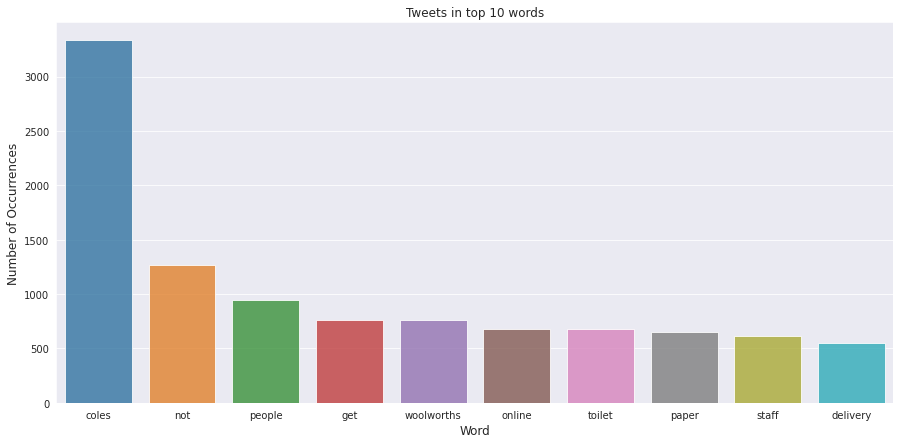

In [ ]:
# Visualize the top word counts 
sns.set_style("darkgrid") #set style for all plots.

word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(15, 7)) #plotsize
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

In [ ]:
from PIL import Image
from wordcloud import WordCloud

<Figure size 432x288 with 0 Axes>

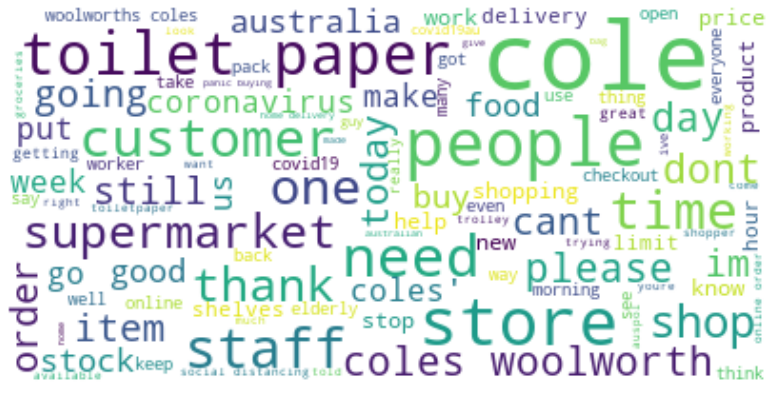

In [ ]:
corpus = list(df['tweet'])

wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.figure(figsize=(15, 7)) #plotsize
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Remove common words

In [ ]:
# Creating a list of custom stopwords (domain relevant and misspelled stop words)
# note - we have retained cole as it appears to have an alternate meaning and we made need to isolate these tweets at a later stage.
new_words_to_remove = ["coles", "woolworths", "aldi", "iga", "shop", "woolies", "australia", "im", "dont", "didnt", "thats"]

In [ ]:
# Remove common words
# We will use lambda function here.
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(5)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tweet_stem
0,1256783985499205634,1256783985499205634,1588475626000,2020-05-03,03:13:46,UTC,403197899,stewart17oakden,Stewart Johnston,NaN,enlighten u would disclaimer fully support don...,['coles'],[],[],1,0,0,['#covid19au'],[],https://twitter.com/Stewart17Oakden/status/125...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '403197899', 'username': 'Stewart...",NaN,NaN,NaN,NaN,enlighten u would disclaim fulli support that ...
1,1256770046199689218,1256770046199689218,1588472303000,2020-05-03,02:18:23,UTC,260726460,volks2911,Volkan Kalayci * 🔴⚽️🔴⚽️,NaN,making shoppers pack bags minimize contact glo...,['coles'],[],[],0,0,0,"['#covid__19', '#scam', '#lazy']",[],https://twitter.com/volks2911/status/125677004...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '260726460', 'username': 'volks29...",NaN,NaN,NaN,NaN,make shopper pack bag minim contact gloveless ...
2,1256746444360278016,1256438381514387457,1588466676000,2020-05-03,00:44:36,UTC,900604458589052928,janemangel,Jane Angel,NaN,not talking fruit vegies would understand talk...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JaneMAngel/status/12567464...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '900604458589052928', 'username':...",NaN,NaN,NaN,NaN,im not talk fruit vegi would understand im tal...
3,1256727968140849152,1256475821981622272,1588462271000,2020-05-02,23:31:11,UTC,23501166,jeneng,Jennifer (wash your hands) English,NaN,figtree every week nothing professional since ...,['coles'],[],[],1,0,0,[],[],https://twitter.com/JenEng/status/125672796814...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '23501166', 'username': 'JenEng'}...",NaN,NaN,NaN,NaN,figtre shop everi week noth profession sinc st...
4,1256692773127766018,1256433718421417985,1588453879000,2020-05-02,21:11:19,UTC,1866363362,lemuriankaryn,Karyn Jane is staying home 🔮🌞,NaN,good see fyi experience westfield plenty valle...,"['coles', 'hcheese_board']",[],[],0,0,1,[],[],https://twitter.com/lemuriankaryn/status/12566...,False,NaN,0,NaN,NaN,user,NaN,NaN,NaN,"[{'user_id': '1866363362', 'username': 'lemuri...",NaN,NaN,NaN,NaN,good see fyi experi cole westfield plenti vall...


In [ ]:
#New word frequency
# Create a word frequency series.
word_frequency = pd.Series(' '.join(df['tweet']).split()).value_counts()

In [ ]:
# Top 10 common words
word_frequency[:10]  

not         1269
people       941
get          763
toilet       678
online       678
paper        654
staff        613
delivery     551
store        536
need         497
dtype: int64

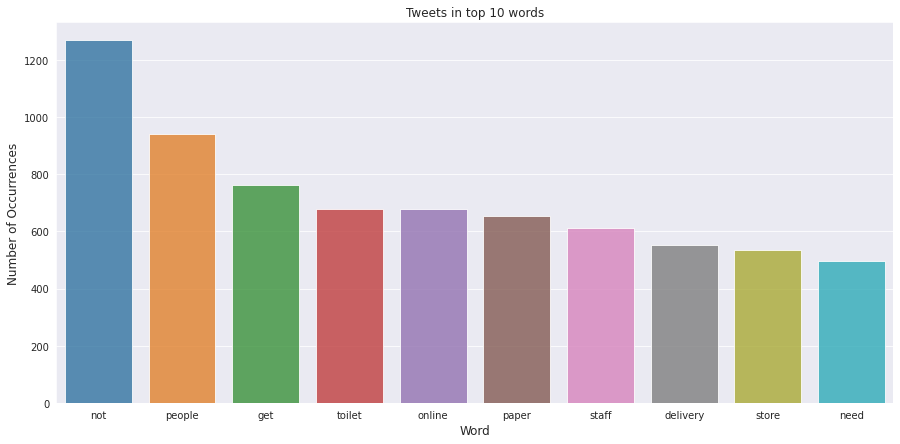

In [ ]:
# Visualize the top word counts 
word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(15, 7)) #plotsize
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.savefig('wordfrequency.png', dpi=800)

<Figure size 432x288 with 0 Axes>

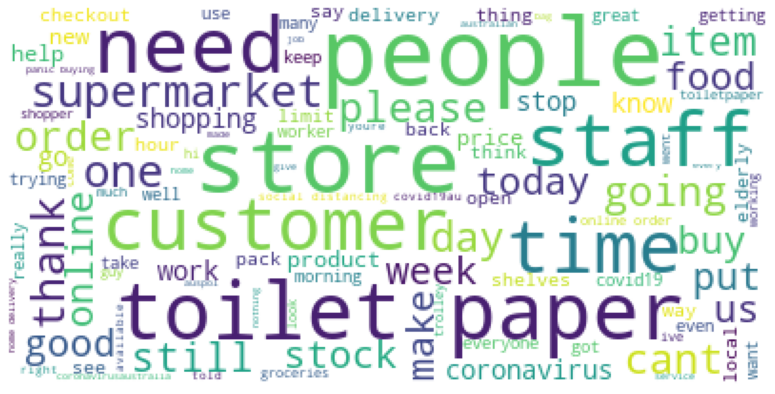

In [ ]:
corpus = list(df['tweet'])

wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordcloud.png', dpi=800)

## N-grams (Bigrams + Trigrams)

### Bigrams

In [ ]:
# This function will generate most frequently occuring Bigrams
def get_ngrams(corpus, ngram_range=(2, 2)):
    
    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [ ]:
bigrams = get_ngrams(df['tweet'].tolist(), ngram_range=(2, 2))

In [ ]:
#convert bigrams to a dataframe
df_bigrams = pd.DataFrame(bigrams)
df_bigrams.columns=["Bi-gram", "Freq"]

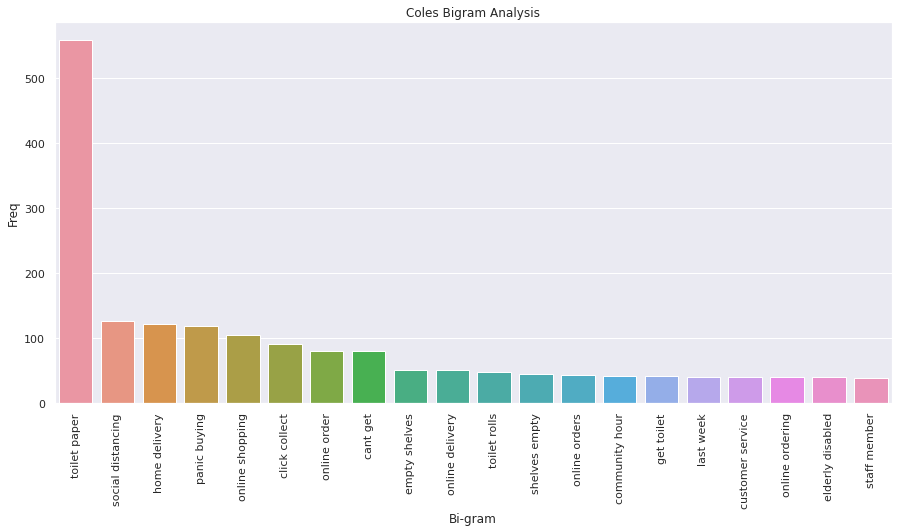

In [ ]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(15,7)})
h=sns.barplot(x="Bi-gram", y="Freq", data=df_bigrams[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Coles Bigram Analysis')
plt.savefig('bigram.png', dpi=800)

### Trigrams

In [ ]:
#Most frequently occuring Tri-grams
def get_trigrams(corpus):
    vec1 = CountVectorizer(ngram_range=(3,3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [ ]:
trigrams = get_ngrams(df['tweet'].tolist(), ngram_range=(3, 3))

In [ ]:
df_trigrams = pd.DataFrame(trigrams)
df_trigrams.columns=["Tri-gram", "Freq"]

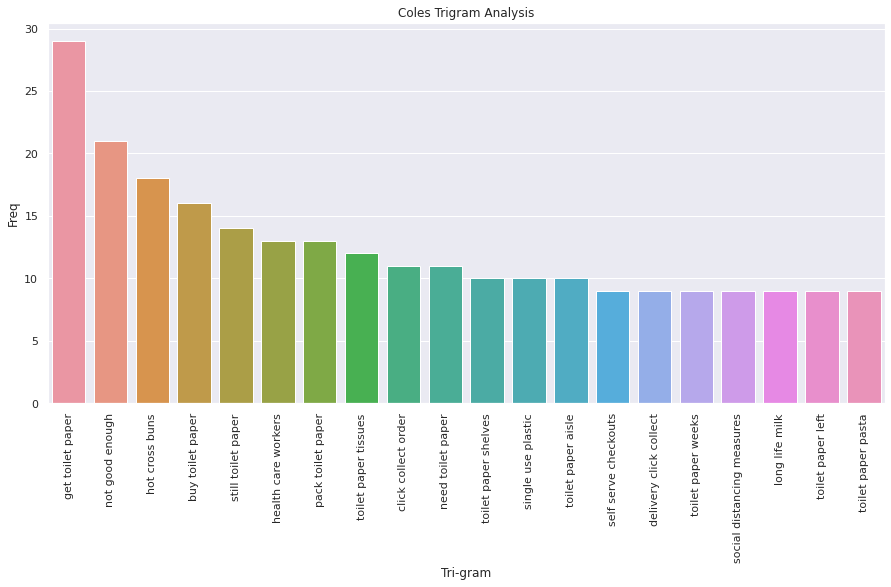

In [ ]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(15,7)})
h=sns.barplot(x="Tri-gram", y="Freq", data=df_trigrams[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90) 
plt.title('Coles Trigram Analysis')
plt.savefig('trigram.png', dpi=800)

In [ ]:
# Top 20 trigrams words
df_trigrams[:20]

,Tri-gram,Freq
0,get toilet paper,29
1,not good enough,21
2,hot cross buns,18
3,buy toilet paper,16
4,still toilet paper,14
5,health care workers,13
6,pack toilet paper,13
7,toilet paper tissues,12
8,click collect order,11
9,need toilet paper,11


## Temporal Analysis

In [ ]:
# Group the twitter datasets based on the date field and get the count per each day.
df.date = pd.to_datetime(df.date)
df_date_wise = df.groupby(['date'])['tweet'].count().reset_index(name='tweet_count')

In [ ]:
#validate
df_date_wise.head() 

,date,tweet_count
0,2020-01-01,13
1,2020-01-02,16
2,2020-01-03,25
3,2020-01-04,31
4,2020-01-05,32


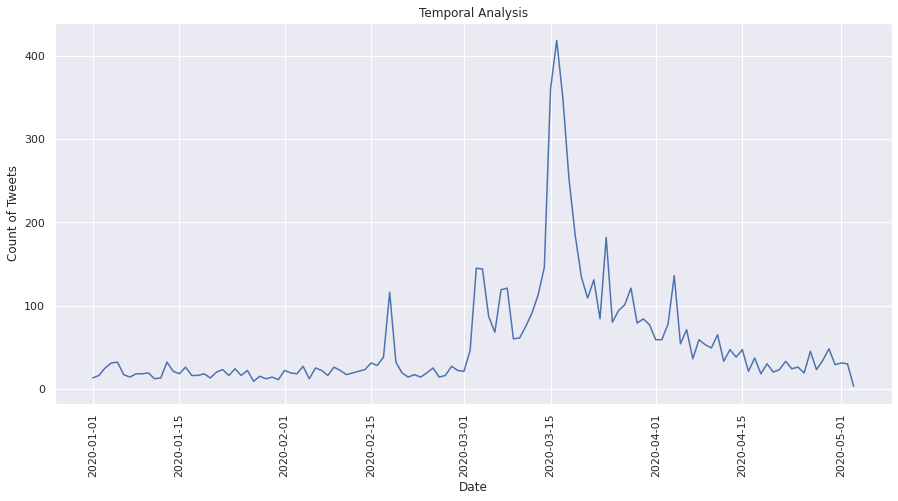

In [ ]:
# Plot twitter activity timeline.
plt.figure(figsize=(15, 7)) 
sns.lineplot(x="date", y="tweet_count", legend="full", data=df_date_wise)
plt.title('Temporal Analysis')
plt.ylabel('Count of Tweets', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=90)
plt.savefig('temporal_analysis.png', dpi=800)

# **Text Analytics**

## Sentiment Analysis

Analyse sentiments for each tweet, aggregate into the sentiment of particular day and derive a sentiment timeline.

In [ ]:
# Extract sentiments from the tweets (This should take some time because we run this to the entire dataset.)
df['sentiment'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
# Display first 50 tweets with respective sentiment value
df[['tweet', 'sentiment']].head(50)

,tweet,sentiment
0,enlighten u would disclaimer fully support don...,0.050000
1,making shoppers pack bags minimize contact glo...,-0.250000
2,not talking fruit vegies would understand talk...,0.083333
3,figtree every week nothing professional since ...,0.100000
4,good see fyi experience westfield plenty valle...,0.066667
5,satisfaction guarantee still apply trash bags ...,-0.194444
6,sell nice food thank enjoy cooking,0.500000
7,hi eastland,0.000000
8,sent dm,0.000000
9,sending emails customers encouraging download ...,0.000000


In [ ]:
#Aggregate the sentiment value (using mean)
df_senti_date_wise = df.groupby(['date'])['sentiment'].mean().reset_index(name='mean_sentiment')

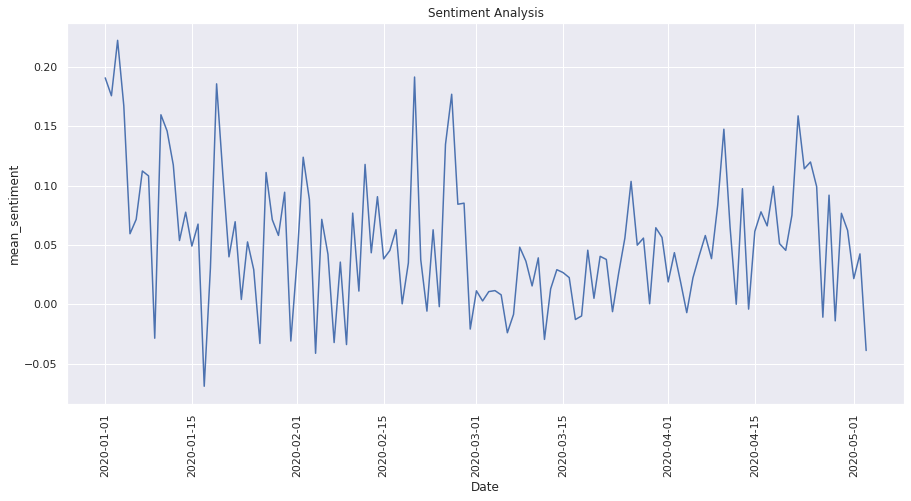

In [ ]:
# Plot twitter activity timeline.
plt.figure(figsize=(15, 7)) 
sns.lineplot(x="date", y="mean_sentiment", legend="full", data=df_senti_date_wise)
plt.title('Sentiment Analysis')
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=90)
plt.savefig('sentiment_analysis.png', dpi=800)

In [ ]:
#sort by mean sentiment (top 5, bottom 5)
# Create a new data frame from the original sorted by the column mean sentiment
df_sorted = df_senti_date_wise.sort_values( by ='mean_sentiment', ascending = False)
df_sorted.head() #top 5

,date,mean_sentiment
2,2020-01-03,0.222248
50,2020-02-20,0.191343
0,2020-01-01,0.190626
18,2020-01-19,0.185615
56,2020-02-26,0.176851


In [ ]:
df_sorted.tail() #bottom 5

,date,mean_sentiment
25,2020-01-26,-0.032955
39,2020-02-09,-0.033894
123,2020-05-03,-0.038889
34,2020-02-04,-0.041246
16,2020-01-17,-0.068986


## Topic Modeling

Utilising topic modeling algorithm LDA (Latent Dirichlet Allocation).

In [ ]:
# Setting up the environment for LDA algorithm.

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


### FIX - SHOULD WE USE LEMMATIZED OR NOT?





In [ ]:
# Convert the lemmatized tweets as the text corpus.
corpus = list(df['tweet'])

In [ ]:
# Tokanization
coles_texts = [[word for word in str(document).split()] for document in corpus]

In [ ]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(coles_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'coles.dict'))

2020-05-03 11:17:52,122 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-03 11:17:52,267 : INFO : built Dictionary(14919 unique tokens: ['anyone', 'bagwhy', 'bare', 'belt', 'covid19au']...) from 6805 documents (total 98685 corpus positions)
2020-05-03 11:17:52,268 : INFO : saving Dictionary object under /tmp/coles.dict, separately None
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-05-03 11:17:52,279 : INFO : saved /tmp/coles.dict


In [ ]:
# Print the dictionary
print(dictionary.token2id)

{'anyone': 0, 'bagwhy': 1, 'bare': 2, 'belt': 3, 'covid19au': 4, 'disclaimer': 5, 'done': 6, 'enlighten': 7, 'fully': 8, 'instructions': 9, 'nothing': 10, 'on2': 11, 'operator': 12, 'ops': 13, 'perplexing': 14, 'provides': 15, 'registerwe': 16, 'rigidly': 17, 'scans': 18, 'staff': 19, 'support': 20, 'touch': 21, 'u': 22, 'unload': 23, 'w': 24, 'wont': 25, 'would': 26, 'bags': 27, 'cashiers': 28, 'contact': 29, 'covid19': 30, 'gloveless': 31, 'groceries': 32, 'handing': 33, 'handling': 34, 'lazy': 35, 'makes': 36, 'making': 37, 'minimize': 38, 'norm': 39, 'pack': 40, 'post': 41, 'scam': 42, 'sense': 43, 'shoppers': 44, 'tippingng': 45, 'us': 46, 'fruit': 47, 'ham': 48, 'increases': 49, 'items': 50, 'many': 51, 'not': 52, 'one': 53, 'packaged': 54, 'price': 55, 'ridiculous': 56, 'talking': 57, 'understand': 58, 'vegies': 59, 'appears': 60, 'assuring': 61, 'back': 62, 'checkout': 63, 'every': 64, 'fast': 65, 'figtree': 66, 'get': 67, 'nonpacking': 68, 'pause': 69, 'professional': 70, 'sca

In [ ]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in coles_texts]

In [ ]:
# Corpus in machine readable format.
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)], [(26, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1)], [(10, 1), (19, 1), (26, 1), (44, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1)], [(77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1)], [(27, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 2)], [(1

### Generate Topic Model

In [ ]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

2020-05-03 11:17:52,485 : INFO : collecting document frequencies
2020-05-03 11:17:52,486 : INFO : PROGRESS: processing document #0
2020-05-03 11:17:52,536 : INFO : calculating IDF weights for 6805 documents and 14918 features (94331 matrix non-zeros)


In [ ]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus]

In [ ]:
total_topics = 10

In [ ]:
# Build the LDA topic model (inputs - corpus, dictionary and # of topics)
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2020-05-03 11:17:52,644 : INFO : using symmetric alpha at 0.1
2020-05-03 11:17:52,646 : INFO : using symmetric eta at 0.1
2020-05-03 11:17:52,652 : INFO : using serial LDA version on this node
2020-05-03 11:17:52,677 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 6805 documents, updating model once every 2000 documents, evaluating perplexity every 6805 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-03 11:17:52,678 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-05-03 11:17:52,679 : INFO : PROGRESS: pass 0, at document #2000/6805
2020-05-03 11:17:53,854 : INFO : merging changes from 2000 documents into a model of 6805 documents
2020-05-03 11:17:53,878 : INFO : topic #4 (0.100): 0.012*"people" + 0.010*"online" + 0.009*"get" + 0.008*"stores" + 0.008*"staff" + 0.007*"us" + 0.007*"not" + 0.007*"bags" + 0.007*"order" + 0.006

In [ ]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=6)

[(0,
  '0.011*"plastic" + 0.011*"home" + 0.010*"delivery" + 0.008*"get" + 0.007*"staff" + 0.006*"online"'),
 (1,
  '0.011*"please" + 0.010*"not" + 0.008*"food" + 0.008*"australian" + 0.005*"china" + 0.005*"auspol"'),
 (2,
  '0.009*"coronavirus" + 0.008*"staff" + 0.007*"store" + 0.007*"not" + 0.006*"today" + 0.005*"supermarket"'),
 (3,
  '0.012*"coronavirusaustralia" + 0.007*"people" + 0.006*"not" + 0.006*"one" + 0.006*"staff" + 0.006*"stores"'),
 (4,
  '0.017*"toiletpaper" + 0.008*"online" + 0.008*"get" + 0.008*"people" + 0.007*"toilet" + 0.007*"order"'),
 (5,
  '0.026*"toilet" + 0.023*"paper" + 0.017*"people" + 0.017*"not" + 0.010*"shelves" + 0.010*"coronavirus"'),
 (6,
  '0.023*"toilet" + 0.023*"paper" + 0.012*"buying" + 0.010*"not" + 0.010*"panic" + 0.009*"people"'),
 (7,
  '0.016*"online" + 0.015*"toiletpaperpanic" + 0.012*"order" + 0.012*"not" + 0.012*"toiletpapergate" + 0.010*"delivery"'),
 (8,
  '0.009*"like" + 0.007*"not" + 0.006*"million" + 0.006*"auspol" + 0.005*"would" + 0.0

### Interactive topic analyzer

Understanding the visualisation [here](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

2020-05-03 11:18:03,522 : INFO : NumExpr defaulting to 2 threads.


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      32.420952   8.115230       1        1  40.075874
3       0.648955  71.707100       2        1  10.809554
9      71.019684   9.971006       3        1   9.665034
2       3.785981  33.185135       4        1   7.988743
6     -42.666500  -9.222070       5        1   6.444931
5      -3.621689 -43.526516       6        1   5.013494
4      -3.632402  -4.171708       7        1   5.001540
1     -36.584400  35.804413       8        1   5.000412
8      44.391380  50.615383       9        1   5.000258
0      40.235809 -31.591665      10        1   5.000160, topic_info=                  Term       Freq      Total Category  logprob  loglift
592             toilet  37.000000  37.000000  Default  30.0000  30.0000
589              paper  36.000000  36.000000  Default  29.0000  29.0000
3279  toiletpaperpanic  39.000000  39.000000  Default  28.0000  28.0000
3955   toiletpapergate  31.000000  31.000000  Default  27.0000  27.0000
3695       toiletpaper  11.000000  11.000000  Default  26.0000  26.0000
...                ...        ...        ...      ...      ...      ...
3695       toiletpaper   0.967869  11.872800  Topic10  -5.8624   0.4888
898           shopping   1.052521  28.130726  Topic10  -5.7785  -0.2900
914                 go   0.958183  16.323967  Topic10  -5.8724   0.1603
64               every   0.887715   8.913436  Topic10  -5.9488   0.6890
132          available   0.856228   8.167828  Topic10  -5.9849   0.7403

[727 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4378      1  0.929284        1st
8544      8  0.795214        20m
3850      4  0.602405      9news
1204      3  1.241249  abandoned
3851      3  0.669281    abcnews
...     ...       ...        ...
26        9  0.086113      would
390       7  0.405394       year
390       9  0.405394       year
2367      8  1.211576         yr
9837      2  1.171786    zealand

[927 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 10, 3, 7, 6, 5, 2, 9, 1])

# **Holding Bay for Code / Ideas**

words appearing out of context - jcole j cole kendrick

In [ ]:
#how do we limit responses to Australia only
#c.Near          = 'Melbourne'

#or do we do it by
#c.To           = '@Coles'


Still to do
- topic modelling with bigrams and ngrams
- Text Classification
- Text Prediction
- Text Summarization
- Text Generation